# Forecasting Hourly Energy Consumption with LightGBM

Light Gradient Boosting is a method of tree boosting that differs from XGBoost in one primary way. LightGBM grows trees leaf-wise, rather than level-wise as would other gradient boosting methods. 

Notebook found at: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost/data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

### Basic EDA

In [3]:
pjme.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
len(pjme)

145366

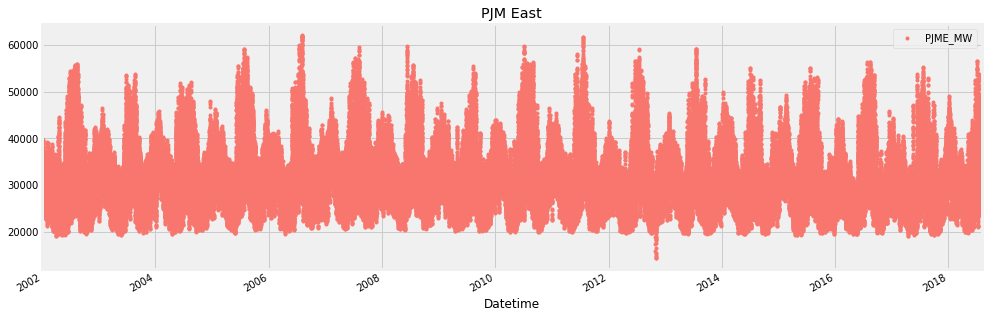

In [5]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### Train/Test Split

In [6]:
split_date = '01-JAN-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

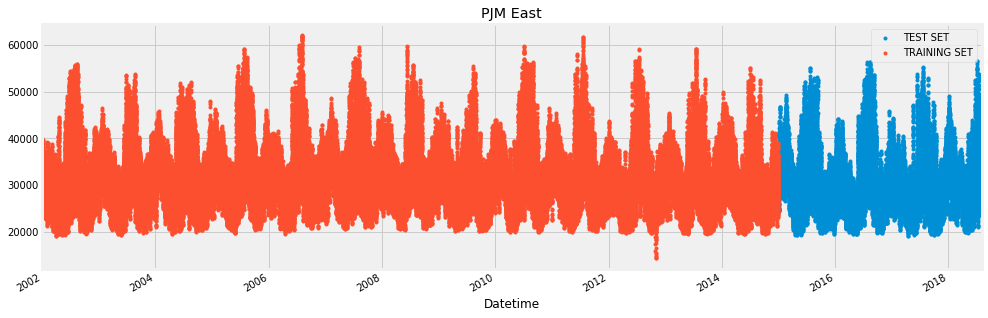

In [7]:
temp_plot = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

### Create Features

In [8]:
def create_lagged_features(df, lag_count):
    """Creates lagged features"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['PJME_MW'].shift(i+1)

    return df

In [9]:
def create_features(df, lag_count, label=None):
    """Creates time series from a datetime index"""
    # Date Features
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first N (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first N (not enough lagged variables)
    X = X[lag_count:]
    
    return X

In [10]:
lag_count = 2

X_train, y_train = create_features(pjme_train, lag_count, label='PJME_MW')
X_test, y_test = create_features(pjme_test, lag_count, label='PJME_MW')

In [11]:
print("PJME SHAPE: ", pjme.shape)
print("X_train SHAPE: ", X_train.shape)
print("X_test SHAPE: ", X_test.shape)
print("Dif in rows (expecting lag_count*2): ", pjme.shape[0]-(X_train.shape[0]+X_test.shape[0]))

PJME SHAPE:  (145366, 1)
X_train SHAPE:  (113925, 10)
X_test SHAPE:  (31437, 10)
Dif in rows (expecting lag_count*2):  4


### Create LightGBM Model

In [12]:
start = datetime.datetime.now()



reg = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.1, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, metric='mse')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train
end = datetime.datetime.now()
print("Total runtime for XGBoost: ", end-start)

[1]	training's l2: 3.42352e+07	valid_1's l2: 3.49005e+07
Training until validation scores don't improve for 50 rounds.
[2]	training's l2: 2.82426e+07	valid_1's l2: 2.87179e+07
[3]	training's l2: 2.41853e+07	valid_1's l2: 2.44903e+07
[4]	training's l2: 2.30375e+07	valid_1's l2: 2.33299e+07
[5]	training's l2: 2.20669e+07	valid_1's l2: 2.25411e+07
[6]	training's l2: 2.12036e+07	valid_1's l2: 2.18946e+07
[7]	training's l2: 1.7764e+07	valid_1's l2: 1.82924e+07
[8]	training's l2: 1.722e+07	valid_1's l2: 1.78687e+07
[9]	training's l2: 1.51482e+07	valid_1's l2: 1.5632e+07
[10]	training's l2: 1.27367e+07	valid_1's l2: 1.32431e+07
[11]	training's l2: 1.08988e+07	valid_1's l2: 1.12945e+07
[12]	training's l2: 1.07001e+07	valid_1's l2: 1.10781e+07
[13]	training's l2: 9.10403e+06	valid_1's l2: 9.50553e+06
[14]	training's l2: 8.95642e+06	valid_1's l2: 9.39538e+06
[15]	training's l2: 7.79925e+06	valid_1's l2: 8.16195e+06
[16]	training's l2: 7.71602e+06	valid_1's l2: 8.06934e+06
[17]	training's l2: 7.6

[152]	training's l2: 723289	valid_1's l2: 1.10486e+06
[153]	training's l2: 721810	valid_1's l2: 1.10526e+06
[154]	training's l2: 719553	valid_1's l2: 1.10183e+06
[155]	training's l2: 719034	valid_1's l2: 1.10184e+06
[156]	training's l2: 717217	valid_1's l2: 1.09769e+06
[157]	training's l2: 715440	valid_1's l2: 1.09352e+06
[158]	training's l2: 715390	valid_1's l2: 1.09395e+06
[159]	training's l2: 715208	valid_1's l2: 1.09407e+06
[160]	training's l2: 714163	valid_1's l2: 1.09275e+06
[161]	training's l2: 705697	valid_1's l2: 1.08263e+06
[162]	training's l2: 700938	valid_1's l2: 1.07956e+06
[163]	training's l2: 699861	valid_1's l2: 1.07826e+06
[164]	training's l2: 695474	valid_1's l2: 1.07548e+06
[165]	training's l2: 692049	valid_1's l2: 1.07376e+06
[166]	training's l2: 692031	valid_1's l2: 1.0738e+06
[167]	training's l2: 691484	valid_1's l2: 1.07318e+06
[168]	training's l2: 689634	valid_1's l2: 1.06849e+06
[169]	training's l2: 686591	valid_1's l2: 1.0653e+06
[170]	training's l2: 681169	va

[318]	training's l2: 551223	valid_1's l2: 871927
[319]	training's l2: 549477	valid_1's l2: 869706
[320]	training's l2: 549331	valid_1's l2: 869786
[321]	training's l2: 549140	valid_1's l2: 869357
[322]	training's l2: 549104	valid_1's l2: 869579
[323]	training's l2: 548104	valid_1's l2: 868661
[324]	training's l2: 548070	valid_1's l2: 868685
[325]	training's l2: 548052	valid_1's l2: 868783
[326]	training's l2: 547901	valid_1's l2: 868821
[327]	training's l2: 547746	valid_1's l2: 868600
[328]	training's l2: 546879	valid_1's l2: 867735
[329]	training's l2: 546858	valid_1's l2: 867494
[330]	training's l2: 546608	valid_1's l2: 866734
[331]	training's l2: 545672	valid_1's l2: 865354
[332]	training's l2: 544930	valid_1's l2: 864518
[333]	training's l2: 544925	valid_1's l2: 864643
[334]	training's l2: 544921	valid_1's l2: 864757
[335]	training's l2: 543739	valid_1's l2: 863579
[336]	training's l2: 543722	valid_1's l2: 863482
[337]	training's l2: 543530	valid_1's l2: 862165
[338]	training's l2:

[488]	training's l2: 501016	valid_1's l2: 794654
[489]	training's l2: 500531	valid_1's l2: 793936
[490]	training's l2: 500383	valid_1's l2: 793413
[491]	training's l2: 500196	valid_1's l2: 792509
[492]	training's l2: 500100	valid_1's l2: 792427
[493]	training's l2: 499919	valid_1's l2: 792430
[494]	training's l2: 499841	valid_1's l2: 791994
[495]	training's l2: 499814	valid_1's l2: 791879
[496]	training's l2: 499804	valid_1's l2: 791796
[497]	training's l2: 499722	valid_1's l2: 791001
[498]	training's l2: 499507	valid_1's l2: 790774
[499]	training's l2: 499492	valid_1's l2: 790608
[500]	training's l2: 499325	valid_1's l2: 790628
[501]	training's l2: 499306	valid_1's l2: 790518
[502]	training's l2: 499299	valid_1's l2: 790571
[503]	training's l2: 499283	valid_1's l2: 790483
[504]	training's l2: 499268	valid_1's l2: 790379
[505]	training's l2: 499261	valid_1's l2: 790379
[506]	training's l2: 499259	valid_1's l2: 790249
[507]	training's l2: 499256	valid_1's l2: 790113
[508]	training's l2:

[659]	training's l2: 475355	valid_1's l2: 756346
[660]	training's l2: 475355	valid_1's l2: 756414
[661]	training's l2: 475318	valid_1's l2: 755638
[662]	training's l2: 475314	valid_1's l2: 755589
[663]	training's l2: 474910	valid_1's l2: 755280
[664]	training's l2: 474806	valid_1's l2: 754919
[665]	training's l2: 474585	valid_1's l2: 754565
[666]	training's l2: 474524	valid_1's l2: 754363
[667]	training's l2: 474520	valid_1's l2: 754300
[668]	training's l2: 474435	valid_1's l2: 754259
[669]	training's l2: 474377	valid_1's l2: 754213
[670]	training's l2: 474265	valid_1's l2: 753763
[671]	training's l2: 474262	valid_1's l2: 753724
[672]	training's l2: 473151	valid_1's l2: 751849
[673]	training's l2: 473038	valid_1's l2: 752556
[674]	training's l2: 472948	valid_1's l2: 753247
[675]	training's l2: 472938	valid_1's l2: 753334
[676]	training's l2: 472912	valid_1's l2: 753173
[677]	training's l2: 472842	valid_1's l2: 752148
[678]	training's l2: 472839	valid_1's l2: 752111
[679]	training's l2:

[829]	training's l2: 456248	valid_1's l2: 731063
[830]	training's l2: 455950	valid_1's l2: 730681
[831]	training's l2: 455903	valid_1's l2: 730714
[832]	training's l2: 455874	valid_1's l2: 730279
[833]	training's l2: 455737	valid_1's l2: 730557
[834]	training's l2: 455488	valid_1's l2: 730662
[835]	training's l2: 455427	valid_1's l2: 731283
[836]	training's l2: 455400	valid_1's l2: 731116
[837]	training's l2: 455395	valid_1's l2: 731182
[838]	training's l2: 455390	valid_1's l2: 731020
[839]	training's l2: 455342	valid_1's l2: 730692
[840]	training's l2: 455295	valid_1's l2: 730404
[841]	training's l2: 455153	valid_1's l2: 730261
[842]	training's l2: 455049	valid_1's l2: 730176
[843]	training's l2: 455047	valid_1's l2: 730130
[844]	training's l2: 455036	valid_1's l2: 730137
[845]	training's l2: 454981	valid_1's l2: 730128
[846]	training's l2: 454721	valid_1's l2: 729941
[847]	training's l2: 454696	valid_1's l2: 729917
[848]	training's l2: 454689	valid_1's l2: 729911
[849]	training's l2:

[1000]	training's l2: 439217	valid_1's l2: 711271
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 439217	valid_1's l2: 711271
Total runtime for XGBoost:  0:00:18.299051


### Forecast on Test Set

In [13]:
# Drop first ten rows of test set because X currently drops 10 rows **FIX THIS**
pjme_test = pjme_test[lag_count:]

In [14]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

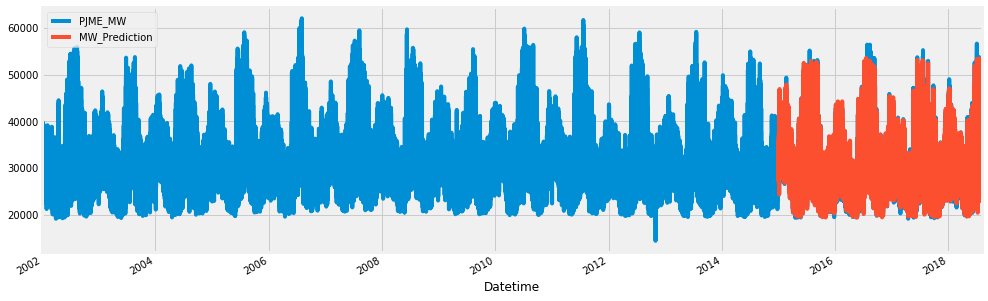

In [15]:
temp_plot = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

### A look at the first month of predictions

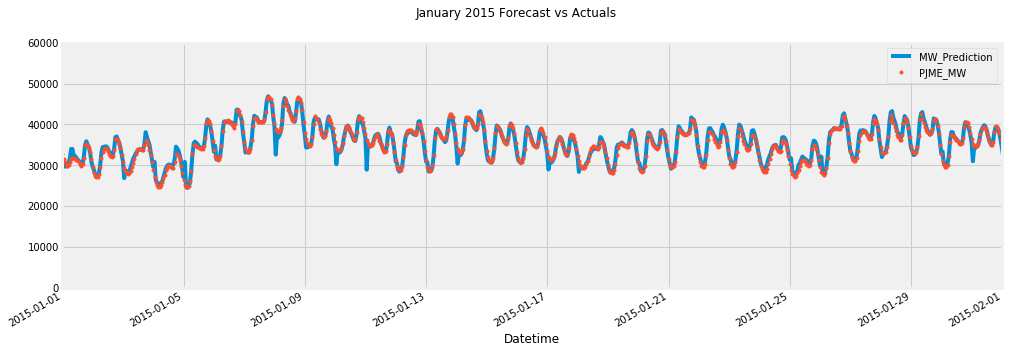

In [16]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_chart = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

### A look at the first week of predictions

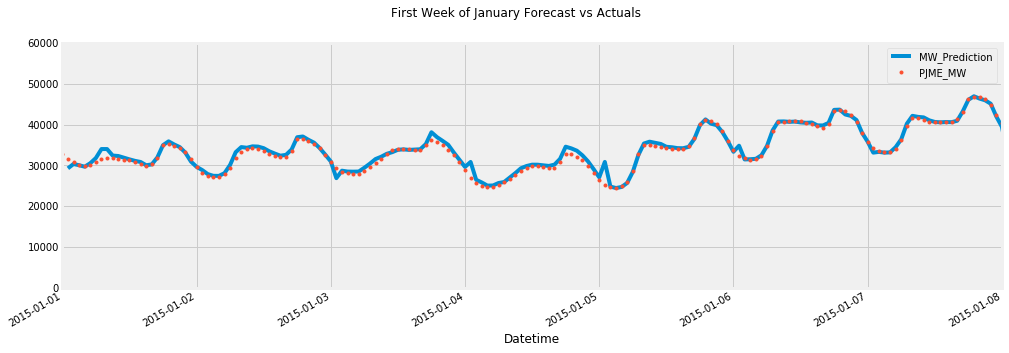

In [17]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

### A look at the another week of predictions

This time, we take a look at the first week of July

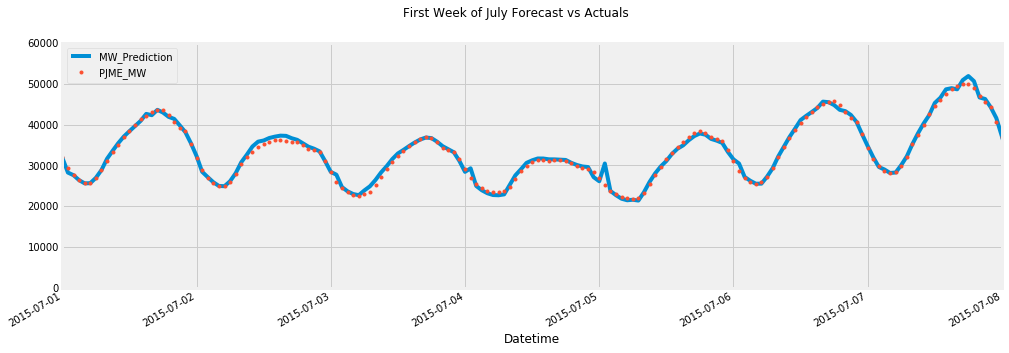

In [18]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

### Plotting Residuals

In [19]:
pjme_all['error'] = pjme_all['MW_Prediction'] - pjme_all['PJME_MW']

In [20]:
pjme_test['error'] = pjme_test['MW_Prediction'] - pjme_test['PJME_MW']

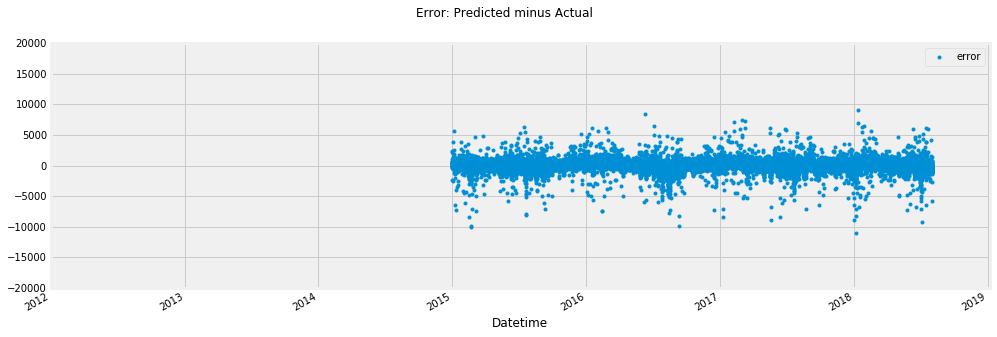

In [21]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_plot = pjme_all[['error']].plot(ax=ax,
                                              style=['.'])
ax.set_xbound(lower='01-01-2012', upper='01-08-2019')
ax.set_ylim(-20000, 20000)
plot = plt.suptitle('Error: Predicted minus Actual')

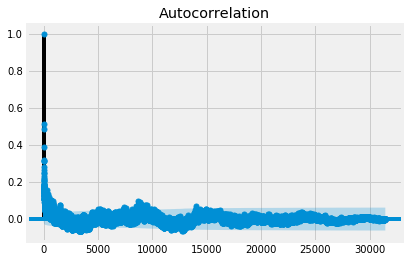

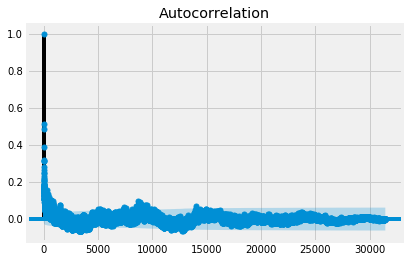

In [22]:
# Plotting Autocorrelation
# Autocorrelation = 1 is perfect correlation
from statsmodels.graphics.tsaplots import plot_acf
series = pjme_test['error']
plot_acf(series)

### Durbin Watson Test

In [23]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(pjme_test['error'])

1.02885339333811

In [24]:
pjme_test['error'][0]

375.2048132123746

In [25]:
top = 0
bot = 0

for i in range(1, len(pjme_test['error'])):
    temp_top = (pjme_test['error'][i] - pjme_test['error'][i-1])**2
    temp_bot = pjme_test['error'][i]**2
    
    top += temp_top
    bot += temp_bot
    
print("TOP: ", top)
print("BOT: ", bot)
print("DW: ", top/bot)

TOP:  23005391238.052513
BOT:  22360082152.05322
DW:  1.0288598709795007


### Error Metrics on Test Set

Error metrics looked at:
* RMSE (Root Mean Squared Error)
* MAE (Mean Absolute Error)
* MAPE (Mean Absolute Percentage Error)

In [26]:
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
# Evaluate
i = 'MW_Prediction'
print("MSE: ", mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
print("RMSE: ", math.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i])))
print("MAE: ", mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test[i]))
print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(pjme_test['PJME_MW'], pjme_test[i]), 4)))
print("\n")

MSE:  711270.8887840697
RMSE:  843.3687738967276
MAE:  542.0409428639227
Mean Absolute Percentage Error: 1.7344%




### Worst vs Best Predicted Days

In [28]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
pjme_test['abs_error_pct'] = pjme_test['abs_error']/pjme_test['PJME_MW']*100
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error', 'abs_error_pct']]

In [29]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error  \
year month dayofmonth                                                          
2018 1     23          29773.833333   31182.126215 -1408.292882  1408.292882   
2017 2     8           28523.833333   29822.465443 -1298.632110  1298.632110   
2016 6     10          27941.583333   29198.382409 -1256.799076  1275.514615   
2018 1     22          29872.041667   31105.826316 -1233.784649  1233.784649   
2017 3     1           27574.125000   28793.669520 -1219.544520  1219.544520   
     1     25          30449.333333   31611.419317 -1162.085984  1162.085984   
           26          30215.916667   31350.102020 -1134.185353  1134.185353   
2018 1     24          32071.458333   33196.580650 -1125.122317  1125.122317   
2016 1     3           29116.791667   30240.914333 -1124.122666  1124.122666   
     3     1           28898.833333   30014.876851 -1116.043518  1116.043518   

                       abs_error_pct  
year month dayofmonth                 
2018 1     23               4.823531  
2017 2     8                4.659229  
2016 6     10               4.896366  
2018 1     22               4.140620  
2017 3     1                4.625801  
     1     25               3.790822  
           26               3.844262  
2018 1     24               3.700620  
2016 1     3                3.842129  
     3     1                3.874389

As noted in the notebook: 
* Some of the worst misses were holidays, so a holiday indicator could be beneficial

In [30]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction        error    abs_error  \
year month dayofmonth                                                          
2016 8     13          45185.833333   42667.301679  2518.531654  2518.531654   
           12          45724.708333   43305.600133  2419.108200  2419.108200   
           14          44427.333333   42090.046579  2337.286754  2337.286754   
2015 7     20          45447.458333   43184.118195  2263.340138  2263.340138   
2016 7     25          44440.750000   42202.003442  2238.746558  2238.746558   
2018 7     2           45218.125000   43109.258249  2108.866751  2108.866751   
2017 7     20          44770.500000   42760.849446  2009.650554  2009.650554   
2016 8     16          43918.458333   41955.116501  1963.341832  1963.341832   
           15          43938.875000   42114.805330  1824.069670  1857.405847   
           11          45225.458333   43497.341115  1728.117218  1728.117218   

                       abs_error_pct  
year month dayofmonth                 
2016 8     13               5.364180  
           12               5.109381  
           14               5.125995  
2015 7     20               4.865709  
2016 7     25               4.814707  
2018 7     2                4.379424  
2017 7     20               4.418999  
2016 8     16               4.343906  
           15               4.149597  
           11               3.683047

In [31]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error  \
year month dayofmonth                                                        
2016 3     20          27989.416667   27984.999807    4.416860  124.610401   
2015 10    1           27507.500000   27473.077571   34.422429  139.514823   
           28          28500.958333   28552.135124  -51.176791  155.499781   
2016 5     13          26924.333333   26847.484538   76.848796  159.412733   
     10    22          24307.458333   24422.338143 -114.879809  167.220045   
     5     1           24503.625000   24479.892712   23.732288  169.810927   
2015 10    3           25534.875000   25412.944278  121.930722  169.994278   
     9     25          28264.875000   28252.483895   12.391105  178.191295   
2018 4     27          26166.875000   26226.927377  -60.052377  181.914419   
2015 10    29          27411.041667   27432.757678  -21.716011  182.873101   

                       abs_error_pct  
year month dayofmonth                 
2016 3     20               0.443204  
2015 10    1                0.529779  
           28               0.534276  
2016 5     13               0.611245  
     10    22               0.749835  
     5     1                0.689340  
2015 10    3                0.694357  
     9     25               0.659957  
2018 4     27               0.688847  
2015 10    29               0.688754

### Conclusion

The algorithm seems to have predictive power, but does not perform as well or generalize as well as XGBoost. The Durbin-Watson statistic is particularly troubling.

#### RMSE: 843.36

#### Mean Absolute Percentage Error: 1.734%

Additionally, the **DW Statistic** for the overall model is not near two at 1.028, suggesting some autocorrelation of residuals. It seems that LightGBMs are not quite as powerful as XGBoost methods without tuning. However, LightGBM has more than a hundred tuning parameters and could potentially produce the same or better results as XGBoost with more time spent tuning.

